In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import math, re, time, random
from scipy import stats

from tqdm.notebook import tqdm
tqdm.pandas()

import os
os.chdir("I:")

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# os.chdir("C:\\Users\\Insight1\\Anaconda3")
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

C:\Users\Insight1\Anaconda3\envs\tf-gpu\lib\site-packages\tqdm\std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# 1. Preprocess and EDA

In [30]:
# read data from pickle file
data = pd.read_pickle('notes_with_age_and_impairment.pkl')

# change data types to float and int for age and life expectancy
data['age'] = data['age'].astype(float)
data['le'] = data['le'].astype(int)
data['le_year'] = data['le'].apply(lambda x: round(x/12))

data['notes_split'] = data['notes'].str.replace('\n', ' ').str.replace(r' +', ' ').str.split(' ')
data['len_notes'] = data['notes_split'].apply(len)

ave_le = np.average(data['le'].to_numpy())
mode_le = stats.mode(data['le'].to_numpy())
print('Average remaining life span: {} \nMode of remaining life span: {}'.format(ave_le, mode_le[0]))

Average remaining life span: 96.808266996657 
Mode of remaining life span: [72]


## 1.1 First glance of our data

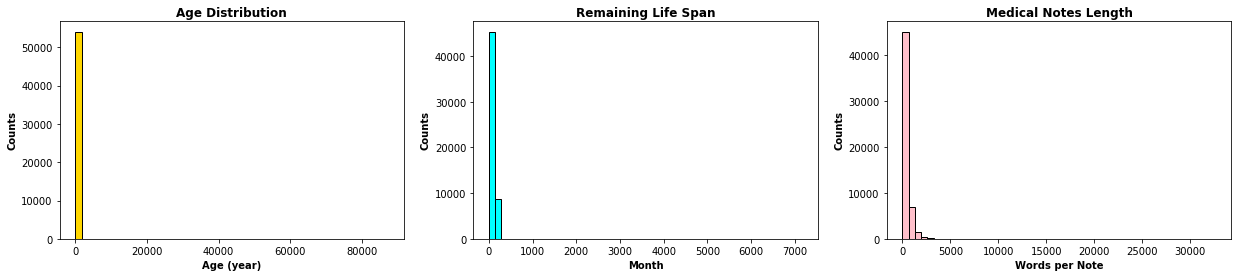

In [31]:
# First glanse of our data
eda = ['age','le','len_notes']
title = ['Age Distribution','Remaining Life Span','Medical Notes Length']
color = ['gold','aqua','pink']
xla =['Age (year)','Month','Words per Note']
# data_eda = data[]
fig, ax = plt.subplots(1,3, figsize=(21,4))
for i, (a, eda) in enumerate(zip(ax,eda)):
    a.hist(data[eda], bins=50, color=color[i], ec='black')
    a.set_ylabel('Counts', fontsize=10,fontweight ='bold')
    a.set_xlabel(xla[i], fontsize=10,fontweight ='bold')
    a.set_title(title[i], fontsize=12, fontweight ='bold',pad =5)

# plt.figure(figsize=(4,3))
# plt.hist(data['age'], bins=50, color='gold', ec='black')
# plt.xlabel('Age (year)', fontsize=10,fontweight ='bold')
# plt.ylabel('Counts', fontsize=10,fontweight ='bold')
# plt.title('Age Distribution', fontsize=12, fontweight ='bold',pad =5)

## 1.2 Preprocess (remove missing/wrong/unrealistic samples) & EDA graphs

In [34]:
filt = (data['len_notes']<=2000) & (data['len_notes']>=10) & (data['le'] <=250) & (data['age'] <=110) & (data['age'] >=60)
datafilt = data[filt]
print(data.shape, datafilt.shape) #97% data remained

(54143, 8) (52516, 8)


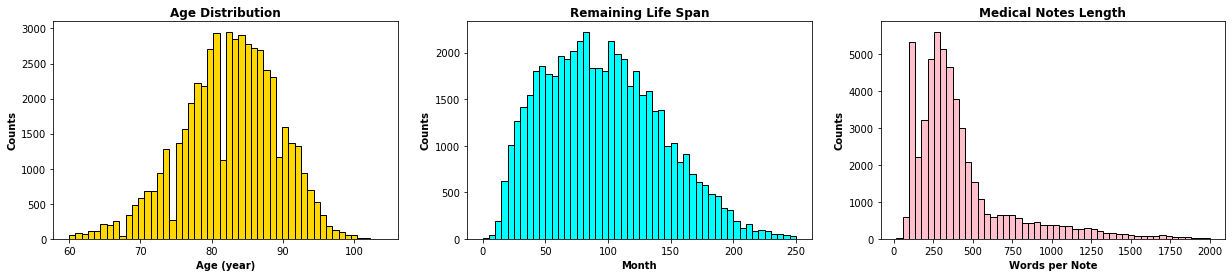

In [35]:
eda = ['age','le','len_notes']
title = ['Age Distribution','Remaining Life Span','Medical Notes Length']
color = ['gold','aqua','pink']
xla =['Age (year)','Month','Words per Note']
# data_eda = data[]
fig, ax = plt.subplots(1,3, figsize=(21,4))
for i, (a, eda) in enumerate(zip(ax,eda)):
    a.hist(datafilt[eda], bins=50, color=color[i], ec='black')
    a.set_ylabel('Counts', fontsize=10,fontweight ='bold')
    a.set_xlabel(xla[i], fontsize=10,fontweight ='bold')
    a.set_title(title[i], fontsize=12, fontweight ='bold',pad =5)

## 1.3 Word cloud

In [38]:
os.chdir("C:\\Users\\Insight1\\Anaconda3")

In [39]:
# data = pd.read_pickle('clean_note_spacy_vec.pkl')
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

filtwc = (data['len_notes'] >= 500) & (data['len_notes'] <= 600)
notewc = data.loc[filtwc, 'notes']
notewc.index = range(notewc.shape[0])

a = random.randrange(len(notewc))

STOPWORDS.update(['noted', 'was', 'say','Was','reported','cited','Vv', 'vv','Wa'])
stopwords = set(STOPWORDS)

wc = WordCloud(width = 800, height = 800, background_color ='white', stopwords = stopwords)
wc.generate(notewc[a])

plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wc) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 
# wc.to_file('note_wc.png')

ImportError: cannot import name 'WordCloud' from 'wordcloud' (unknown location)

# 2. Data Cleaning and Text preprocessing

## 2.1 Remove non alphanumeric characters

In [ ]:
import string
from scipy import stats
def clean(note):
    table = str.maketrans('', '','!"#$%&\'()*+,-./:;<=>?@‘¥£’—“[\\]^_`{|}~«»§é')
    s = note.translate(table)
    s1 = s.replace('\n',' ').lower()
    s2 = re.sub('(\\b[A-Za-z] \\b|\\b [A-Za-z]\\b)', '', s1)
    st_clean = re.sub(r' +', ' ', s2)
    return st_clean

data['notes_clean'] = data['notes'].progress_apply(lambda x: clean(x))
data['len_clean'] = data['notes_clean'].progress_apply(lambda x: len(x.split(' ')))

# import spacy
# nlp = spacy.load('en_core_web_lg')
# data['spacy_notes_clean'] = data['notes_clean'].progress_apply(lambda x: nlp(x).vector)
# data.to_pickle('clean_note_spacy_vec.pkl')
# saved pkl file NO.1
# columns =['key', 'notes', 'le', 'age', 'primary_impairment', 'le_year',
#           'notes_split','len_notes', 'notes_clean', 'len_clean', 'spacy_notes_clean']

### saved pkl file NO.1 columns =
**`['key', 'notes', 'le', 'age', 'primary_impairment', 'le_year','notes_split','len_notes',
'notes_clean', 'len_clean', 'spacy_notes_clean']`**

## 2.2 Tokenization, remove stopwords, stemming, lemmatization

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def lemma_stem_stop(note):
    word_tokens = word_tokenize(note)
    
    # lemmatization
    lemma_words = []
    wordnet_lemmatizer = WordNetLemmatizer()
    for w in word_tokens:
        word1 = wordnet_lemmatizer.lemmatize(w, pos = "n")
        word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
        word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
        lemma_words.append(word3)

    # STOPWORDS
    states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
              "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", "MA", 
              "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", "NM", "NY", 
              "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", 
              "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
    states = [x.lower() for x in states]
    
    stopwd = set(stopwords.words('english'))
    stopwd.update(['note', 'was', 'say','cite','report','vv','ii','iii','report', 'disclaim','disclaimer',
                   'request','underwrite','underwriter','life','expect','certify','take','company',
                  'id','written','write','ssn','social','security','number','llc','use']) 
    stopwd.update(states)
    filtered_sentence = [w for w in lemma_words if not w in stopwd] # can switch lemma or stem words
    
    #Stemming
    Stem_words = []
    ps =PorterStemmer()
    for w in filtered_sentence:
        rootWord=ps.stem(w)
        Stem_words.append(rootWord)
    
    lemma_stop_stem = Stem_words
    return lemma_stop_stem

In [ ]:
data['lss_notes'] = data['notes_clean'].progress_apply(lambda x: lemma_stem_stop(x))
data['len_lss'] = data['lss_notes'].progress_apply(lambda x: len(x))
data['lss_corpus'] = data['lss_notes'].progress_apply(lambda x: ' '.join(x))

In [ ]:
data.to_pickle('clean_note_spacy_vec_lss_spacy.pkl')
# saved pkl file NO.2
# columns = ['key', 'notes', 'le', 'age', 'primary_impairment', 'le_year', 'notes_split', 'len_notes', 'notes_clean', 
#           'len_clean', 'spacy_notes_clean', 'lss_notes', 'len_lss', 'lss_corpus','spacy_lss_corpus']

### saved pkl file NO.2 columns =
**`['key', 'notes', 'le', 'age', 'primary_impairment', 'le_year', 'notes_split', 'len_notes', 
'notes_clean', 'len_clean', 'spacy_notes_clean', 
'lss_notes', 'len_lss', 'lss_corpus', 'spacy_lss_corpus']`**

## 2.3 Feature Extraction (Vectorize by spacy, or Bag of words, or TF-IDF)

### Spacy vectorization

In [ ]:
# vectorize cleaned corpus by spacy 
data['spacy_lss_corpus'] = data['lss_corpus'].progress_apply(lambda x: nlp(x).vector)

### Bag of Words, TF-IDF

In [2]:
data = pd.read_pickle('clean_note_spacy_vec_lss_spacy.pkl') #load data for tf-idf
data.columns

Index(['key', 'notes', 'le', 'age', 'primary_impairment', 'le_year',
       'notes_split', 'len_notes', 'notes_clean', 'len_clean',
       'spacy_notes_clean', 'lss_notes', 'len_lss', 'lss_corpus',
       'spacy_lss_corpus'],
      dtype='object')

In [3]:
# os.chdir("C:\\Users\\Insight1\\Anaconda3")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# transform len_lss
filt = (data['len_lss']<=2000) & (data['len_lss']>=50) & (data['le'] <=250) & (data['age'] <=100) & (data['age'] >=60)
data_tfidf = data[filt][['age', 'le','le_year','lss_notes','lss_corpus']]

corpus = data_tfidf['lss_corpus'].tolist()
vec = CountVectorizer()
bag_of_words = vec.fit_transform(corpus)
sum_words = bag_of_words.sum(axis=0) # sum word counts
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)

# return words_freq[:n]
vocab = [i[0] for i in words_freq[:4000]] # define vocabulary for tf-idf data most frequent 4000 words

vectorizer = TfidfVectorizer(vocabulary=vocab)
corpus_tfidf = vectorizer.fit_transform(corpus)

# 3. Prepare data for model

### 3.1 Load spacy vectorized notes for  Model input

In [ ]:
# data=pd.read_pickle('clean_note_spacy_vec.pkl')

filt = (data['len_notes']<=2000) & (data['len_notes']>=50) & (data['le'] <=250) & (data['age'] <=100) & (data['age'] >=60)
data1 = data[filt]

X = data1['spacy_notes_clean'].to_numpy()
X = np.array([i for i in X]).reshape(52475,300) #X = np.concatenate(X).reshape(54143,300)
x_age = np.expand_dims(data1['age'].to_numpy(), axis=1)

X = np.hstack((x_age, X))
y = data1['le'].to_numpy() 

### 2.Load spacy vectorize lss_corpus for Model input

In [ ]:
# data = pd.read_pickle('clean_note_spacy_vec_lss_spacy.pkl')

filt = (data['len_notes']<=2000) & (data['len_notes']>=50) & (data['le'] <=250) & (data['age'] <=100) & (data['age'] >=60)
data_spacylss_filt = data[filt]

X = np.array(data_spacylss_filt['spacy_lss_corpus'].values.tolist())
x_age = np.expand_dims(data_spacylss_filt['age'].to_numpy(), axis=1)

# X y from spacy vector of lss_corpus for Model
X = np.hstack((x_age, X))
y = data_spacylss_filt['le'].to_numpy() 
# y = data_spacylss_filt['le_year']

### Save X y numpy to pkl.npy for different models

In [4]:
X = corpus_tfidf.toarray()
x_age = np.expand_dims(data_tfidf['age'].to_numpy(), axis = 1)

# X y from tf-idf for Model
X = np.hstack((x_age, X))
y = data_tfidf['le'].to_numpy() 
# y = data_spacylss_filt['le_year']

# save X and y to pickle file
# np.save('tfidf_X_4001.pkl', X)
# np.save('tfidf_y.pkl', y)
# X=np.load('tfidf_X_4001.pkl.npy', allow_pickle=True)
# y=np.load('tfidf_y.pkl.npy', allow_pickle=True)

In [ ]:
print(X.shape, y.shape)

# 4. Model

In [ ]:
print(X.shape, y.shape)

In [ ]:
from sklearn.model_selection import train_test_split
# 80%/20% split for train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 70%/10%/20% split for train/validation/test
# X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.125, random_state=42)

In [ ]:
# normalization of age based on min and max of x-train
a = X_train[:, 0].max()
b = X_train[:, 0].min()
X_train[:, 0] = (X_train[:, 0]-b)/(a-b)
X_test[:, 0] = (X_test[:, 0]-b)/(a-b)

In [ ]:
# df_y_pred dataframe to store y_pred from model
# df_score dataframe to store mae, train_r2, test_r2
df_pred_ytest = pd.DataFrame()
df_pred_ytrain = pd.DataFrame()
df_score = pd.DataFrame(index=['MAE','train_r2','test_r2'])

##  Random Forest

### 4.1 RF model & feature importances

In [ ]:
# random forest regressor score = 0.5402527642512915 for 57k data
# rf regressor r2 = 0.5560166555170266 when filted len_word<=750, le_months<=250
# rf regressor r2 = 0.5384426783146021 when filted 100<=len_word<=2000, le_months<=250 on noteclean_spacy_vec
# rf reg spacy_lss r2= 0.5800088178042535 for 50-1000 len_lss, le_months<250
# r2 = 0.9483540267963761 0.6502525420270096 for n_estimator 100
# r2 = 0.9482949319146955 0.6514315694118593 for n_estimator 50
# r2 = 0.9482869107367904 0.6494406487369414 for n_estimator 30
# the above are r2 for notes without age

from sklearn.ensemble import RandomForestRegressor 
reg_rf = RandomForestRegressor(n_estimators = 30, random_state = 0)

reg_rf = RandomForestRegressor().fit(X_train, y_train)
y_test_rf = reg_rf.predict(X_test)
y_train_rf = reg_rf.predict(X_train)

# feature importances from model
importances = reg_rf.feature_importances_

# R squared from model
rf_train_score = reg_rf.score(X_train, y_train)
rf_test_score = reg_rf.score(X_test, y_test)

# calculate mean absolute residual
rf_mae = sum(np.absolute(y_test_rf - y_test))/y_test.size


print(rf_mae, rf_train_score, rf_test_score)
# r2 = 0.983937158661077 0.8860908022722117
# mae = 9.713297711394068   r2 =0.9841633938912728 0.8873791244281546 for n_est =30
# mae = 9.788619451742454   r2 =0.9840451957775558 0.8854066362163049 for n_est =20

In [ ]:
# save predicted training and testing data into dataframe
df_pred_ytrain['y_train_rf'] = y_train_rf
df_pred_ytest['y_test_rf'] = y_test_rf
df_score['rf'] =[rf_mae, rf_train_score, rf_test_score]
df_score

In [ ]:
# plot feature importances
vip_idx = np.argsort(np.absolute(importances))[::-1]
importances_sort = [importances[i] for i in vip_idx]

vocab.insert(0,'age') 
vip_name = [vocab[i] for i in vip_idx]
print(len(vocab), len(vip_name))

plt.figure(figsize=(4,8))
plt.barh(range(30)[::-1], importances_sort[1:31], color = 'peru')
plt.yticks(range(30)[::-1], vip_name[1:31], rotation =0, fontsize =12)
plt.ylim(-0.5,29.7)
plt.title('Feature Importance', fontweight='bold', pad =10, fontsize=14)
plt.show()

In [ ]:
# plot R-squared graphs
plt.figure(figsize=(8,8))
plt.scatter(y_train[1000:1500], y_train_rf[1000:1500], label = 'Train', color='black')
plt.scatter(y_test[1000:1500], y_test_rf[1000:1500], label = 'Test', color ='orange')
plt.plot(range(300), range(300), '-k',linestyle ='--')
plt.xlim(0, 260)
plt.ylim(0, 260)
plt.title('Random Forest Regression', fontsize =26, fontweight = 'bold', pad =10)
plt.xlabel('Observed',fontsize =24, fontweight = 'bold')
plt.ylabel('Predicted',fontsize =24, fontweight = 'bold')
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
a = plt.legend(loc='upper left', fontsize = 16)
a.legendHandles[0]._sizes =[90]
a.legendHandles[1]._sizes =[90]
plt.show()
# plt.savefig('Random Forest predicted vs observed.png', dpi = 400)

In [ ]:
# plot residual graphs

# residual = np.absolute(y_test_rf - y_test)
residual = y_test_rf - y_test

plt.figure(figsize= (4,4))
plt.scatter(y_test[:1500], residual[:1500])
plt.axhline(y=rf_mae, color ='k', linestyle ='--')
plt.xlim(0, 250)
plt.ylim(-20, 40)
plt.title('Random Forest Residual', fontsize =16, fontweight = 'bold', pad =10)
plt.xlabel('Observed (month)',fontsize =12, fontweight = 'bold')
plt.ylabel('Residual (month)',fontsize =12, fontweight = 'bold')
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
# plt.show()
# plt.savefig('RF Residual.png', dpi =400)

### 4.2 RF model with only age as input (ablation study)

In [ ]:
# age as the only input
reg_rf = RandomForestRegressor(n_estimators = 40, random_state = 0)
reg_rf = RandomForestRegressor().fit(np.expand_dims(X_train[:, 0], axis=1), y_train)

y_test_rf1 = reg_rf.predict(np.expand_dims(X_test[:, 0], axis=1))
y_train_rf1 = reg_rf.predict(np.expand_dims(X_train[:, 0], axis=1))

rf_train_score1 = reg_rf.score(np.expand_dims(X_train[:, 0], axis=1), y_train)
rf_test_score1 = reg_rf.score(np.expand_dims(X_test[:, 0], axis=1), y_test)

rf1_mae = sum(np.absolute(y_test_rf1-y_test))/y_test.size

print(rf1_mae, rf_train_score1, rf_test_score1) # R^2 variance weighted

In [ ]:
# save predicted training and testing data into dataframe
df_pred_ytrain['y_train_rf_age'] = y_train_rf1
df_pred_ytest['y_test_rf_age'] = y_test_rf1
df_score['rf_age'] =[rf1_mae, rf_train_score1, rf_test_score1]
df_score

### 4.3 Save df_pred_ytrain, df_pred_ytest, df_score to csv file

In [ ]:
#Save predicted y values and R2 scores to csv file
df_pred_ytrain.to_csv('df_pred_ytrain.csv')
df_pred_ytest.to_csv('df_pred_ytest.csv')
df_score.to_csv('df_score.csv')

## 4.2 Multilayer Perceptron Neural Network

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


model = keras.models.Sequential()

model.add(keras.Input(shape=4001,))
model.add(keras.layers.Dense(256, activation='relu', kernel_initializer = 'normal'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(128, activation='relu', kernel_initializer = 'normal'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.3))
# model.add(keras.layers.Dense(512, activation='relu', kernel_initializer = 'normal'))
# model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(units = 1))
model.summary()

model.compile(optimizer= 'adam',loss = 'mean_squared_error')

checkpoint_filepath = '/log'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
    
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    batch_size=10000, epochs=1000, callbacks=[model_checkpoint_callback])

# The model weights (that are considered the best) are loaded into the model.
# model.load_weights(checkpoint_filepath)
print(history.history.keys())

model.load_weights(checkpoint_filepath)

y_train_nn = model.predict(X_train)
y_val_nn = model.predict(X_val)
y_test_nn= model.predict(X_test)

from sklearn.metrics import mean_absolute_error
abs_er = mean_absolute_error(y_test, y_test_nn)
print(abs_er)

from sklearn.metrics import r2_score
rsq_train = r2_score(y_train, y_train_nn)
rsq_val = r2_score(y_val, y_val_nn)
rsq_test = r2_score(y_test, y_test_nn)

print(rsq_train, rsq_val, rsq_test)
# 100 epoches: abs_er= 19.991914022416207; rsq =0.6311475230416835; rsq_train = 0.9392278263642062 
# 20.781554059329675
# 0.6444936458044239 0.5632780303898981 0.5536371000303386

#3000 epoch (512/256/512) abs=23.203737412144314  r2 = 0.768495009799099  0.5852656900697112 0.5530109538595611
#3000 epoch (512/0.3,256/0.3, 512)abs=20.688904906315482 r2 =0.9325278290184188 0.6484640725710789 0.61039924081627


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               1024512   
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

37114/37114 [==============================] - 1s 32us/sample - loss: 1862.2064 - val_loss: 1867.1879
Epoch 130/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1801.6955 - val_loss: 1829.9093
Epoch 131/1000
37114/37114 [==============================] - 1s 31us/sample - loss: 1753.1152 - val_loss: 1773.6122
Epoch 132/1000
37114/37114 [==============================] - 1s 30us/sample - loss: 1693.4656 - val_loss: 1716.3048
Epoch 133/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1645.9828 - val_loss: 1669.2806
Epoch 134/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 1591.4474 - val_loss: 1591.2419
Epoch 135/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 1540.6478 - val_loss: 1552.2052
Epoch 136/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 1493.7376 - val_loss: 1544.1411
Epoch 137/1000
37114/37114 [==============================] - 1s 32us/sample - 

37114/37114 [==============================] - 1s 16us/sample - loss: 160.5303 - val_loss: 233.9610
Epoch 201/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 155.9804 - val_loss: 224.0031
Epoch 202/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 154.0284 - val_loss: 221.9346
Epoch 203/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 148.8036 - val_loss: 222.9245
Epoch 204/1000
37114/37114 [==============================] - 1s 32us/sample - loss: 147.0738 - val_loss: 213.5718
Epoch 205/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 144.3986 - val_loss: 220.4522
Epoch 206/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 140.0955 - val_loss: 215.7166
Epoch 207/1000
37114/37114 [==============================] - 1s 28us/sample - loss: 138.6032 - val_loss: 208.0585
Epoch 208/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 135.4370 -

Epoch 343/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.4937 - val_loss: 179.2845
Epoch 344/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.3850 - val_loss: 179.9791
Epoch 345/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 83.3077 - val_loss: 180.0987
Epoch 346/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 82.0340 - val_loss: 178.5516
Epoch 347/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 82.7369 - val_loss: 179.0745
Epoch 348/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.9334 - val_loss: 178.8486
Epoch 349/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.4165 - val_loss: 178.8419
Epoch 350/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 81.8251 - val_loss: 177.8901
Epoch 351/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 80.

Epoch 415/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.0545 - val_loss: 177.1065
Epoch 416/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.3160 - val_loss: 176.3514
Epoch 417/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.7650 - val_loss: 176.5570
Epoch 418/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 74.5692 - val_loss: 176.9993
Epoch 419/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 74.7171 - val_loss: 175.5775
Epoch 420/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 73.0185 - val_loss: 175.1100
Epoch 421/1000
37114/37114 [==============================] - 1s 33us/sample - loss: 72.0696 - val_loss: 174.6667
Epoch 422/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 72.4425 - val_loss: 175.7387
Epoch 423/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 72.

Epoch 487/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.1532 - val_loss: 176.0934
Epoch 488/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.9204 - val_loss: 175.9462
Epoch 489/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 64.7651 - val_loss: 175.2176
Epoch 490/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 66.1191 - val_loss: 175.1535
Epoch 491/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 66.2240 - val_loss: 176.4120
Epoch 492/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.4880 - val_loss: 176.4063
Epoch 493/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.1692 - val_loss: 175.6827
Epoch 494/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.8924 - val_loss: 175.6837
Epoch 495/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 65.

Epoch 559/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 59.7815 - val_loss: 174.1736
Epoch 560/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 61.0902 - val_loss: 174.5463
Epoch 561/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.5492 - val_loss: 174.3549
Epoch 562/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.0136 - val_loss: 174.1733
Epoch 563/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.8710 - val_loss: 174.7556
Epoch 564/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 60.7456 - val_loss: 173.8392
Epoch 565/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 60.2316 - val_loss: 173.7925
Epoch 566/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 59.2916 - val_loss: 173.8690
Epoch 567/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 59.

Epoch 631/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 56.0682 - val_loss: 174.7413
Epoch 632/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.0814 - val_loss: 175.5967
Epoch 633/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.9908 - val_loss: 176.3200
Epoch 634/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.7328 - val_loss: 175.2302
Epoch 635/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.9471 - val_loss: 174.7107
Epoch 636/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.9241 - val_loss: 174.8188
Epoch 637/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 57.1084 - val_loss: 174.9027
Epoch 638/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 56.3185 - val_loss: 174.7699
Epoch 639/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 57.

Epoch 703/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.3827 - val_loss: 175.7885
Epoch 704/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.5464 - val_loss: 174.2402
Epoch 705/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.6035 - val_loss: 173.8846
Epoch 706/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 54.1874 - val_loss: 174.6767
Epoch 707/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.3679 - val_loss: 174.3296
Epoch 708/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.2843 - val_loss: 174.8938
Epoch 709/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.5489 - val_loss: 175.0929
Epoch 710/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 55.1046 - val_loss: 174.1856
Epoch 711/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.

Epoch 775/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 54.1792 - val_loss: 174.7052
Epoch 776/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 53.3313 - val_loss: 174.8493
Epoch 777/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.3890 - val_loss: 175.5319
Epoch 778/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 54.5048 - val_loss: 174.7684
Epoch 779/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.9017 - val_loss: 174.9356
Epoch 780/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.6569 - val_loss: 175.0238
Epoch 781/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.2453 - val_loss: 174.6198
Epoch 782/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.8300 - val_loss: 174.3403
Epoch 783/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.

Epoch 847/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.1411 - val_loss: 173.9314
Epoch 848/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.5428 - val_loss: 173.6025
Epoch 849/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 52.6612 - val_loss: 174.4303
Epoch 850/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.0827 - val_loss: 173.2749
Epoch 851/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.5245 - val_loss: 172.6824
Epoch 852/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.8220 - val_loss: 173.3212
Epoch 853/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.8416 - val_loss: 173.9347
Epoch 854/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.3298 - val_loss: 173.7660
Epoch 855/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 52.

Epoch 919/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.1372 - val_loss: 173.5991
Epoch 920/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.6817 - val_loss: 173.9417
Epoch 921/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.0367 - val_loss: 173.2182
Epoch 922/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.5901 - val_loss: 172.8603
Epoch 923/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 53.5153 - val_loss: 172.1604
Epoch 924/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.9967 - val_loss: 172.3978
Epoch 925/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.1289 - val_loss: 173.3374
Epoch 926/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.9659 - val_loss: 173.3286
Epoch 927/1000
37114/37114 [==============================] - 1s 14us/sample - loss: 52.

Epoch 991/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.9164 - val_loss: 172.9357
Epoch 992/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.4419 - val_loss: 173.0470
Epoch 993/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 52.1446 - val_loss: 173.0931
Epoch 994/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.0259 - val_loss: 173.2766
Epoch 995/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 51.8708 - val_loss: 173.9113
Epoch 996/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 50.7391 - val_loss: 173.8306
Epoch 997/1000
37114/37114 [==============================] - 1s 15us/sample - loss: 50.7689 - val_loss: 173.4866
Epoch 998/1000
37114/37114 [==============================] - 1s 16us/sample - loss: 51.2904 - val_loss: 174.1196
Epoch 999/1000
37114/37114 [==============================] - 0s 13us/sample - loss: 51.